In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import plotly.graph_objs as go
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.filters.hp_filter import hpfilter # Filtro HP
import calendar


# Desactivar advertencias de tipo FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

In [24]:
df = pd.read_excel('deflactacion_corrientes.xlsx')
df = df.drop('Unnamed: 0',axis=1)
df.set_index('fecha',inplace=True)
df

,id_region_indec,id_provincia_indec,total_facturacion,bebidas,almacen,panaderia,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rostiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronica_hogar,otros
fecha,,,,,,,,,,,,,,
2017-01-01,5,18,414425.891532,55223.974281,93280.928771,19161.332555,31799.710020,52424.653122,16475.949863,13889.575699,53520.859732,11313.453598,27207.559535,39662.069641
2017-02-01,5,18,393554.096105,52277.269334,95111.702479,18678.892501,31539.134417,51979.759497,16524.547555,12775.205734,49428.093109,10054.448362,21156.316372,33553.135218
2017-03-01,5,18,400771.343548,52853.428861,101066.125407,19780.977190,32512.803226,52554.654599,17230.403306,13257.757888,51250.270276,9989.440218,21353.425573,30834.407452
2017-04-01,5,18,411524.235066,50280.324673,110553.618925,21049.554431,31650.966236,54256.122579,15848.447058,13309.966144,51006.932402,12887.983707,23611.241162,29449.348475
2017-05-01,5,18,390927.496548,42314.297385,100641.902610,19761.425514,29896.167973,49624.114859,14179.877376,12517.987065,48910.206875,14040.949159,30447.033033,29814.816273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,5,18,362776.475501,73596.567287,66509.406720,12378.019968,24954.736410,39250.820739,10924.852004,6873.979949,40024.131157,10900.049144,17093.067560,33760.414154
2024-01-01,5,18,282017.922783,46319.147132,52891.972571,10320.213678,23494.183008,28671.613084,10017.838724,5261.152254,34081.619661,6414.874133,12361.931826,24635.877263
2024-02-01,5,18,259887.036689,40663.266321,51263.344643,9717.900665,20869.634644,28810.387901,9996.009597,4865.157902,30093.036106,4932.400807,11456.422642,22770.221265


In [25]:
#Asignacion de meses --> Los usamos posteriormente para los boxplot
df['meses'] = df.index.month

#Lista de columnas
columnas = list(df.columns)
columnas.remove('id_region_indec')
columnas.remove('id_provincia_indec')
columnas.remove('meses')

<h1> Pruebas de TENDENCIA </h1>

In [26]:
for columns in columnas:

    #Asignacion de la columna objetivo
    columna_objetivo = columns

    #la X crea una "tendencia" lineal incremental a partir de 0
    X = np.arange(0, len(df)).reshape(-1, 1) #--> con reshape ajustamos los datos para el modelo
    y = df[columna_objetivo]

    #Creamos modelo y lo ajustamos
    model = LinearRegression()
    model.fit(X, y)
    trend = model.predict(X) #--> Prediccion de tendencia con coeficiente BETA_1

    # Crear el gráfico interactivo
    fig = go.Figure()

    # Agregar la serie original
    fig.add_trace(go.Scatter(x=df.index, y=df[columna_objetivo],
                            mode='lines+markers',
                            name='Facturación de supermercado',
                            marker=dict(symbol='star'),
                            hoverinfo='x+y+text',
                            opacity = 0.5))

    #M.V COMUN
    fig.add_trace(go.Scatter(x=df.index, y=df[columna_objetivo].rolling(window=12).mean(),
                            mode='lines',
                            name='Media movil comun',
                            line=dict(color='green')))
    
    #M.V EXPONENCIAL
    fig.add_trace(go.Scatter(x=df.index, y=df[columna_objetivo].ewm(span=3).mean(),
                            mode='lines',
                            name='Exponencial',
                            line=dict(color='red')))

    #REGRESION LINEAL DE UN COEFICIENTE
    fig.add_trace(go.Scatter(x=df.index, y=trend,
                            mode='lines',
                            name=f'Tendencia de regresión lineal. Coef: {model.coef_[0]:.2f}',
                            line=dict(color='purple')))

    # Configurar el diseño del gráfico
    fig.update_layout(
        title=f'Facturación de {columna_objetivo}',
        xaxis_title='Fechas',
        yaxis_title='Miles de pesos',
        legend_title='Series',
        hovermode='x unified',
        template='plotly_white',

    )

    # Mostrar el gráfico
    fig.show()



Considero que este grafico ayuda a estudiar las estacionalidades de cada categoria del supermercado, ya que vemos a lo largo del año, en que mes se vende mas cada cosa

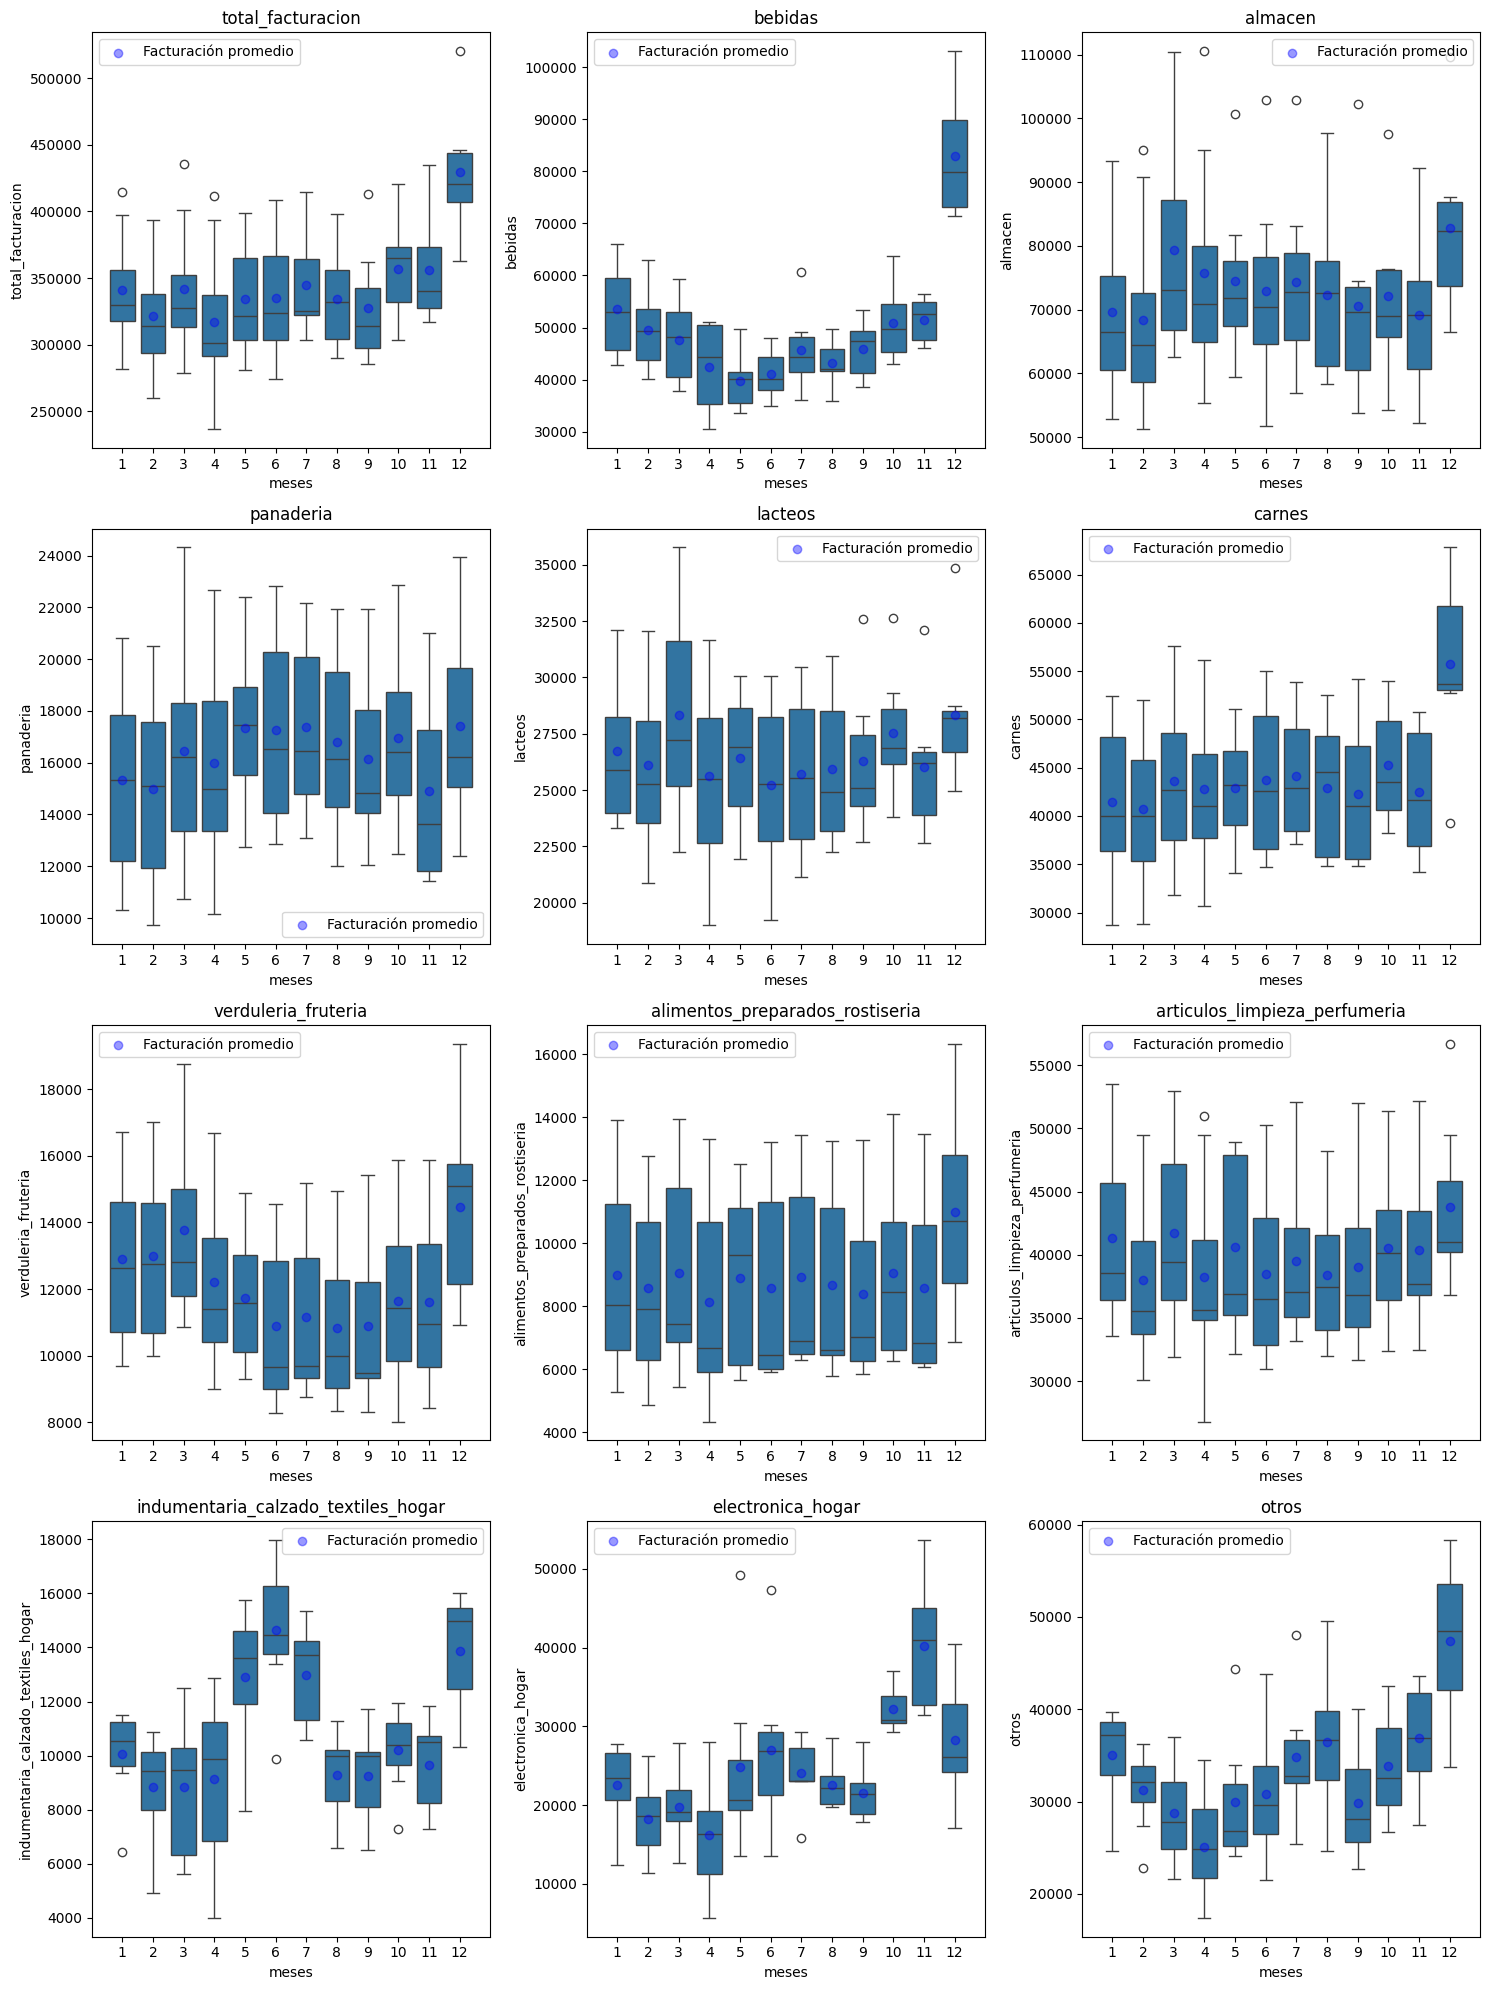

In [27]:
#MESES UNICOS
months = np.unique(df.index.month)


# Crear figura y ejes
fig, axes = plt.subplots(4, 3, figsize=(15, 20))
axes = axes.flatten()

for i, colum in enumerate(columnas):

    #Acumula los datos por mes de cada columna
    acum_data = pd.DataFrame(columns=[colum,'meses'])

    #Lista de promedios por mes
    lista_promedios = []

    #Busqueda de datos por mes
    for month in months:

        data = df[[colum,'meses']][df['meses'] == month]

        lista_promedios.append(data[colum].mean())

        #Grafico de boxplot
        acum_data = pd.concat([acum_data,data]) 
        
    # Gráfico de boxplot
    sns.boxplot(ax=axes[i], x=acum_data['meses'], y=acum_data[colum])
    axes[i].set_title(colum)
    axes[i].scatter(x=np.arange(0, 12), y=lista_promedios, color='blue', alpha=0.4, zorder=5, label="Facturación promedio")
    axes[i].legend()

# Ajustar el layout
plt.tight_layout()
plt.show()

Estudio de las variaciones porcentuales MES A MES Durante cada año

In [28]:
# Obtener los nombres de los meses
months = [calendar.month_name[i] for i in range(1, 13)]

for column in columnas:

    variaciones = df[column].pct_change() * 100

    # Crear el formato de texto para el hover
    text_2017 = [f"2017: {val:.2f}" for val in variaciones[variaciones.index.year == 2017]]
    text_2018 = [f"2018: {val:.2f}" for val in variaciones[variaciones.index.year == 2018]]
    text_2019 = [f"2019: {val:.2f}" for val in variaciones[variaciones.index.year == 2019]]
    text_2020 = [f"2020: {val:.2f}" for val in variaciones[variaciones.index.year == 2020]]
    text_2021 = [f"2021: {val:.2f}" for val in variaciones[variaciones.index.year == 2021]]
    text_2022 = [f"2022: {val:.2f}" for val in variaciones[variaciones.index.year == 2022]]
    text_2023 = [f"2023: {val:.2f}" for val in variaciones[variaciones.index.year == 2023]]
    text_2024 = [f"2024: {val:.2f}" for val in variaciones[variaciones.index.year == 2024]]

    # Crear el gráfico interactivo
    fig = go.Figure()

    #ANO 2017
    fig.add_trace(go.Scatter(x=months, y=variaciones[variaciones.index.year == 2017],
                            mode='lines+markers',
                            name= "2017",
                            marker=dict(symbol='star'),
                            hoverinfo='text',
                            text=text_2017))
    
    #ANO 2018
    fig.add_trace(go.Scatter(x=months, y=variaciones[variaciones.index.year == 2018],
                        mode='lines+markers',
                        name= "2018",
                        marker=dict(symbol='star'),
                        hoverinfo='text',
                        text=text_2018))
    
    #ANO 2019
    fig.add_trace(go.Scatter(x=months, y=variaciones[variaciones.index.year == 2019],
                        mode='lines+markers',
                        name= "2019",
                        marker=dict(symbol='star'),
                        hoverinfo='text',
                        text=text_2019))

    #ANO 2020
    fig.add_trace(go.Scatter(x=months, y=variaciones[variaciones.index.year == 2020],
                        mode='lines+markers',
                        name= "2020",
                        marker=dict(symbol='star'),
                        hoverinfo='text',
                        text=text_2020))
    
    #ANO 2021
    fig.add_trace(go.Scatter(x=months, y=variaciones[variaciones.index.year == 2021],
                        mode='lines+markers',
                        name= "2021",
                        marker=dict(symbol='star'),
                        hoverinfo='text',
                        text=text_2021))    

    #ANO 2022
    fig.add_trace(go.Scatter(x=months, y=variaciones[variaciones.index.year == 2022],
                        mode='lines+markers',
                        name= "2022",
                        marker=dict(symbol='star'),
                        hoverinfo='text',
                        text=text_2022))   
    
    #ANO 2023
    fig.add_trace(go.Scatter(x=months, y=variaciones[variaciones.index.year == 2023],
                        mode='lines+markers',
                        name= "2023",
                        marker=dict(symbol='star'),
                        hoverinfo='text',
                        text=text_2023))   
    
        
    #ANO 2024
    fig.add_trace(go.Scatter(x=months, y=variaciones[variaciones.index.year == 2024],
                        mode='lines+markers',
                        name= "2024",
                        marker=dict(symbol='star'),
                        hoverinfo='text',
                        text=text_2024))   

    # Configurar el diseño del gráfico
    fig.update_layout(
        title=f'Variacion mensual de {column}',
        xaxis_title='Meses',
        yaxis_title='Variación (%)',
        legend_title='Series',
        hovermode='x unified',
        template='plotly_white',
        xaxis=dict(tickmode='array', tickvals=list(range(12)), ticktext=months)
    )

    # Mostrar el gráfico
    fig.show()

Estudiaremos la correlaccion que existe de cada serie con las demas, con el objetivo de estudiar causalidades o relaciones fuertes de venta. Usaremos un periodo anual, es decir, cada punto representara una correlaccion de 12 valores con otros 12 valores.

In [29]:
#Buscamos los años
years = pd.unique(df.index.year)


#Acumulador de datos
mtz_corr = pd.DataFrame(columns=columnas)

for year in years:

    #La var columna es la lista de antes generada especifcamente para los valores
    data_year = df[columnas][df.index.year == year]

    #CORRELACCION POR AÑO
    corr_for_year = data_year.corr()
    corr_for_year['anio'] = year

    #Concatenamos los df's
    mtz_corr = pd.concat([mtz_corr,corr_for_year])


mtz_corr

,total_facturacion,bebidas,almacen,panaderia,lacteos,carnes,verduleria_fruteria,alimentos_preparados_rostiseria,articulos_limpieza_perfumeria,indumentaria_calzado_textiles_hogar,electronica_hogar,otros,anio
total_facturacion,1.000000,0.924407,0.406038,0.624657,0.780630,0.908773,0.762690,0.953892,0.864956,0.587273,0.560218,0.911193,2017.0
bebidas,0.924407,1.000000,0.347175,0.352655,0.840421,0.888955,0.935080,0.916620,0.871958,0.482996,0.312098,0.878517,2017.0
almacen,0.406038,0.347175,1.000000,0.513012,0.226705,0.637266,0.247334,0.377422,0.297599,0.635031,-0.212906,0.097717,2017.0
panaderia,0.624657,0.352655,0.513012,1.000000,0.357067,0.643105,0.154966,0.625642,0.400718,0.399504,0.445470,0.446288,2017.0
lacteos,0.780630,0.840421,0.226705,0.357067,1.000000,0.717170,0.887240,0.807487,0.764868,0.163649,0.315941,0.708705,2017.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
alimentos_preparados_rostiseria,0.633856,0.311921,0.797670,0.986851,0.587969,0.585583,0.602187,1.000000,0.546542,0.327293,0.913763,0.164078,2024.0
articulos_limpieza_perfumeria,0.975786,0.964248,0.091507,0.408867,0.998704,-0.283437,0.714379,0.546542,1.000000,-0.104509,0.819134,0.914226,2024.0
indumentaria_calzado_textiles_hogar,-0.208161,-0.276262,0.011133,0.337814,-0.074504,0.108044,-0.534237,0.327293,-0.104509,1.000000,0.047392,-0.332474,2024.0
electronica_hogar,0.891503,0.655970,0.633074,0.848222,0.845010,0.311482,0.816478,0.913763,0.819134,0.047392,1.000000,0.534183,2024.0


Haremos la grafica de la correlaccion

In [30]:
columnas_mtz = mtz_corr.columns


for column in columnas:

    #Buscamos la correlaccion de cada categoria con las demas, y borramos la 
    #identidad, ya que presenta una correlaccion de la serie consigo misma.
    data = mtz_corr[mtz_corr.index == column].drop(column,axis=1)


    #Columnas de los datos a plotear
    columns_data = list(data.columns)

    #Eliminamos la columna de años
    columns_data.remove('anio')

    
    # Crear una figura
    fig = go.Figure()


    for column_data in columns_data:

        fig.add_trace(go.Scatter(x=pd.unique(data['anio']), y=data[column_data], mode='lines', name=column_data))

  # Configurar layout
    fig.update_layout(
        title=f'Correlación de {column}  con las demás categorías',
        xaxis_title='Año',
        yaxis_title='Correlación',
        hovermode='x unified'
    )
    fig.show()



<h3> Estudio de los ciclos usando el filtro HP</h3>

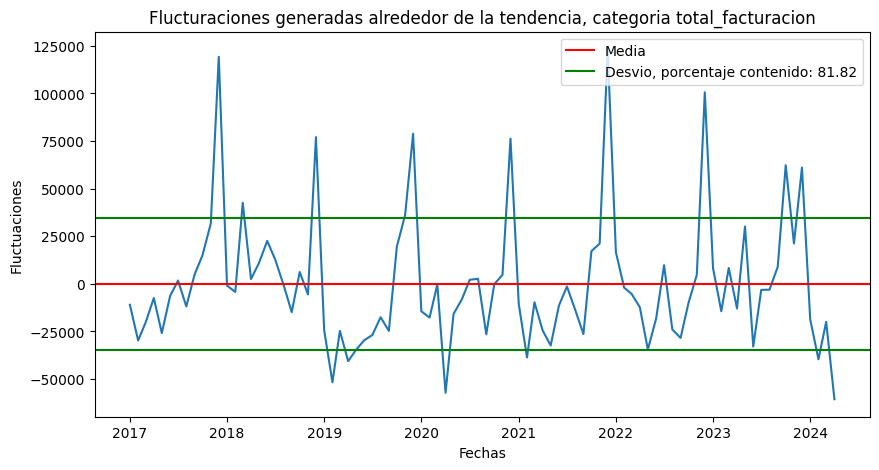

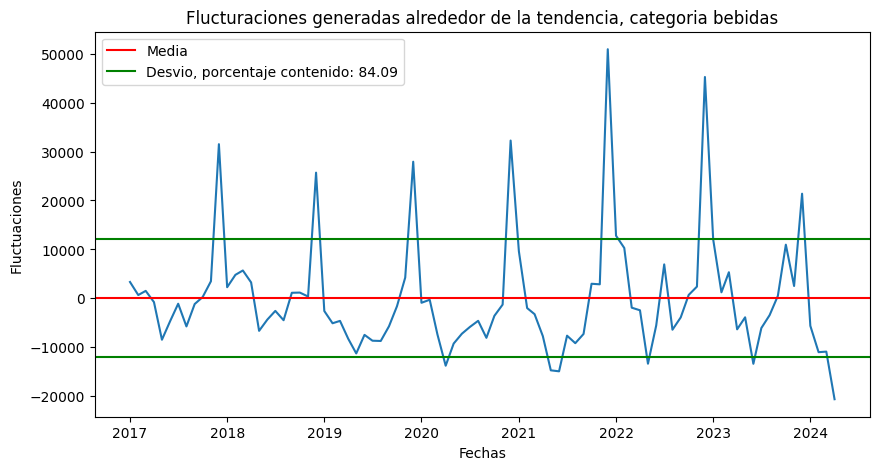

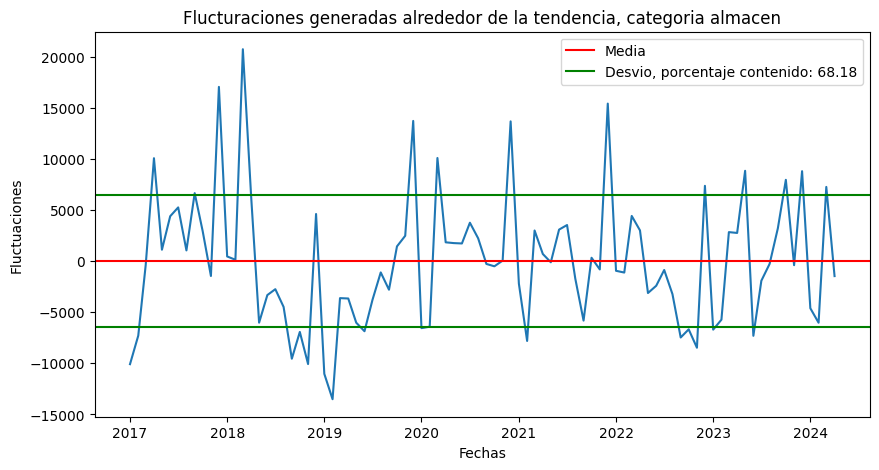

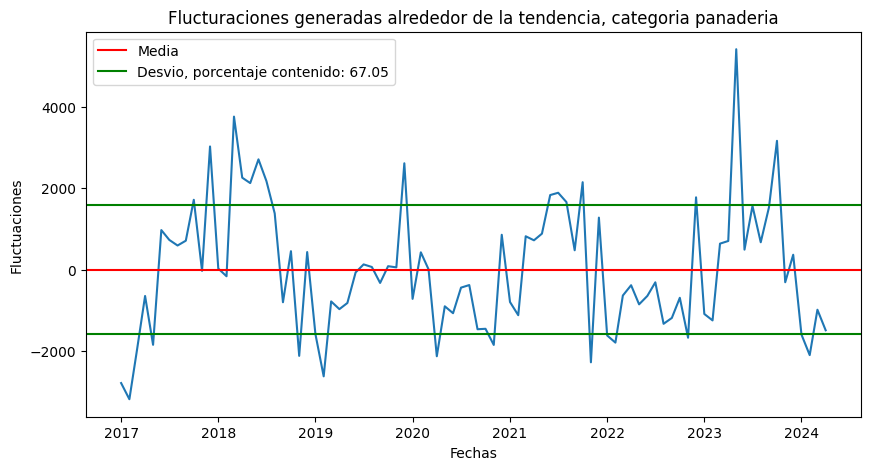

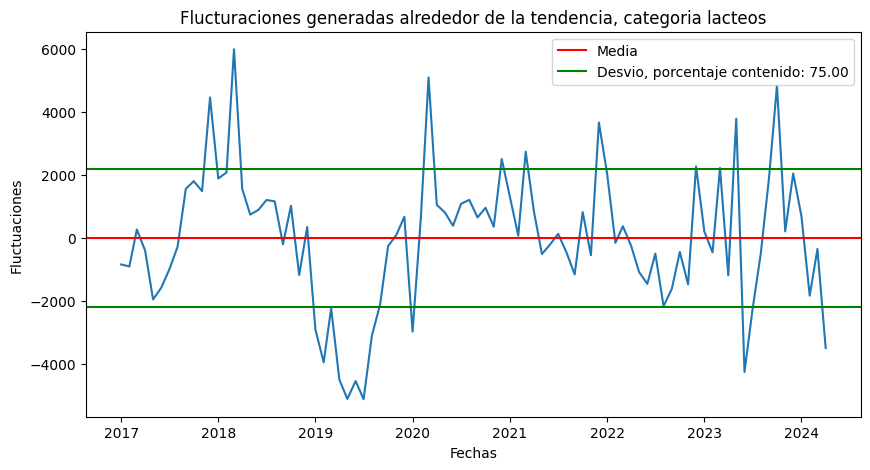

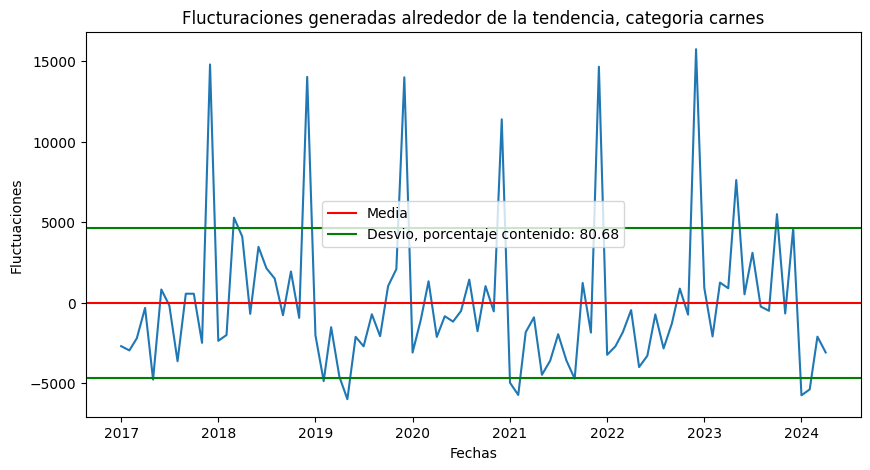

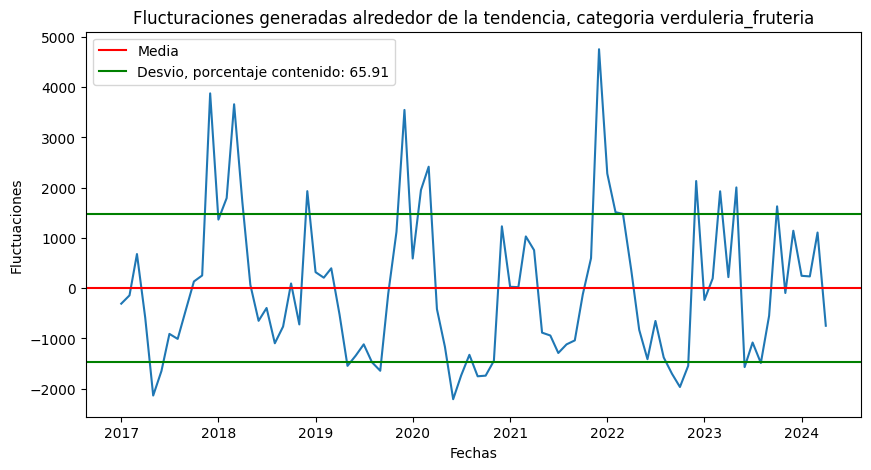

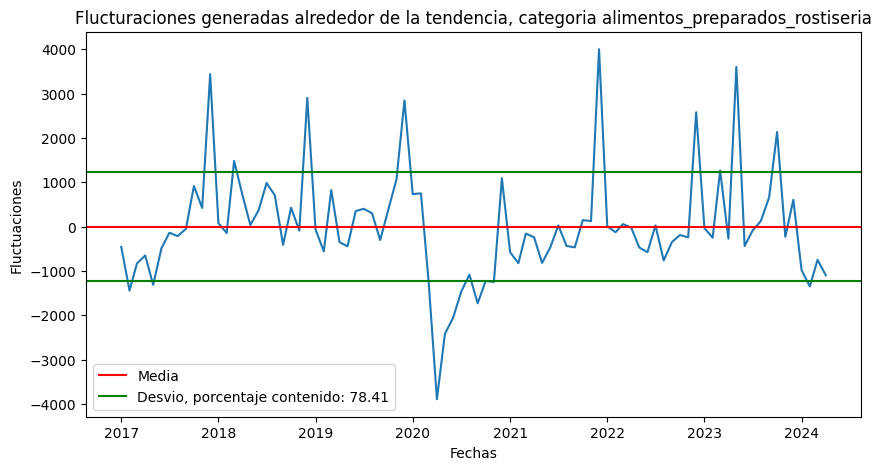

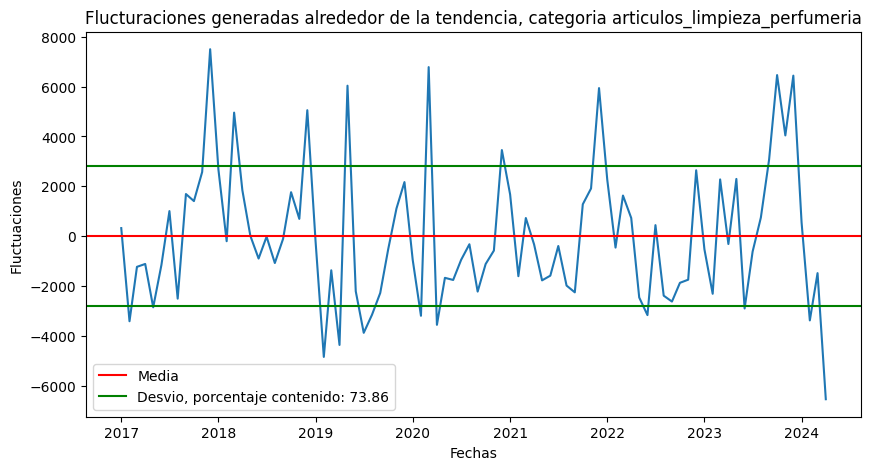

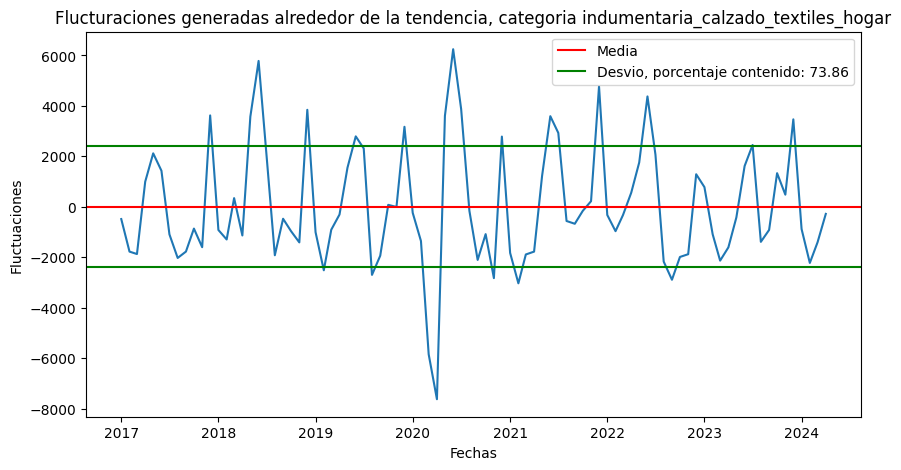

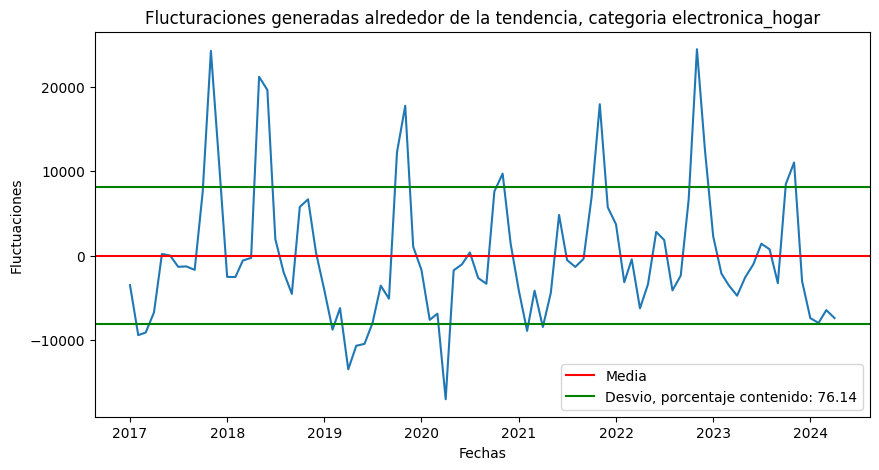

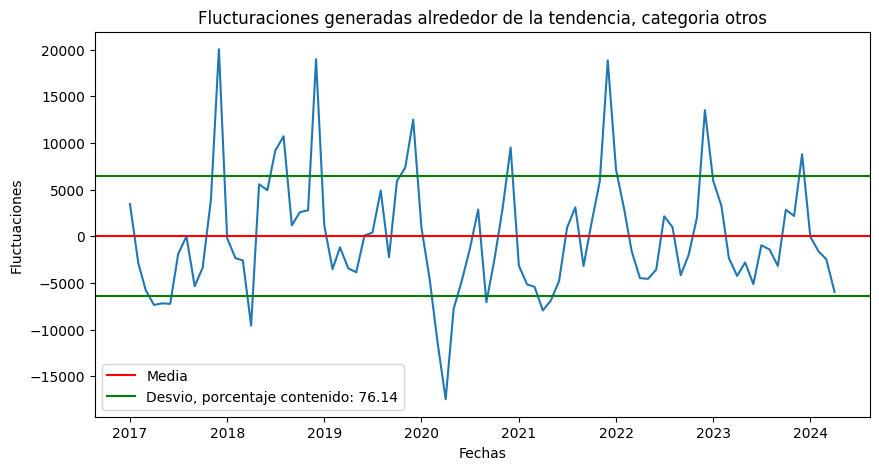

In [32]:
for column in columnas:

    #Calculamos la tendencia y el ciclo
    cycle, trend = hpfilter(df[column],lamb=14400)

    #Ploteamos el ciclo

    #Calculamos el desvio para obtener el porcentaje de datos contenido
    desvio = cycle.std()

    #datos contenidos dentro del desvio
    datos_contenidos = cycle[(cycle >= -desvio) & (cycle <= desvio) ]
    tamano = len(datos_contenidos)

    #Calculo del porcentaje
    porcentaje_contenido = (tamano / len(cycle)) * 100

    plt.figure(figsize=(10,5))
    plt.plot(cycle)
    plt.axhline(cycle.mean(),color = "red",label = "Media")
    plt.axhline(desvio,color = "green",label = f"Desvio, porcentaje contenido: {porcentaje_contenido:.2f}")
    plt.axhline(-desvio,color = "green")
    plt.title(f"Flucturaciones generadas alrededor de la tendencia, categoria {column}")
    plt.ylabel("Fluctuaciones")
    plt.xlabel("Fechas")
    plt.legend()
    plt.show()


<h1> Promedios anuales de ventas por categoria </h1>

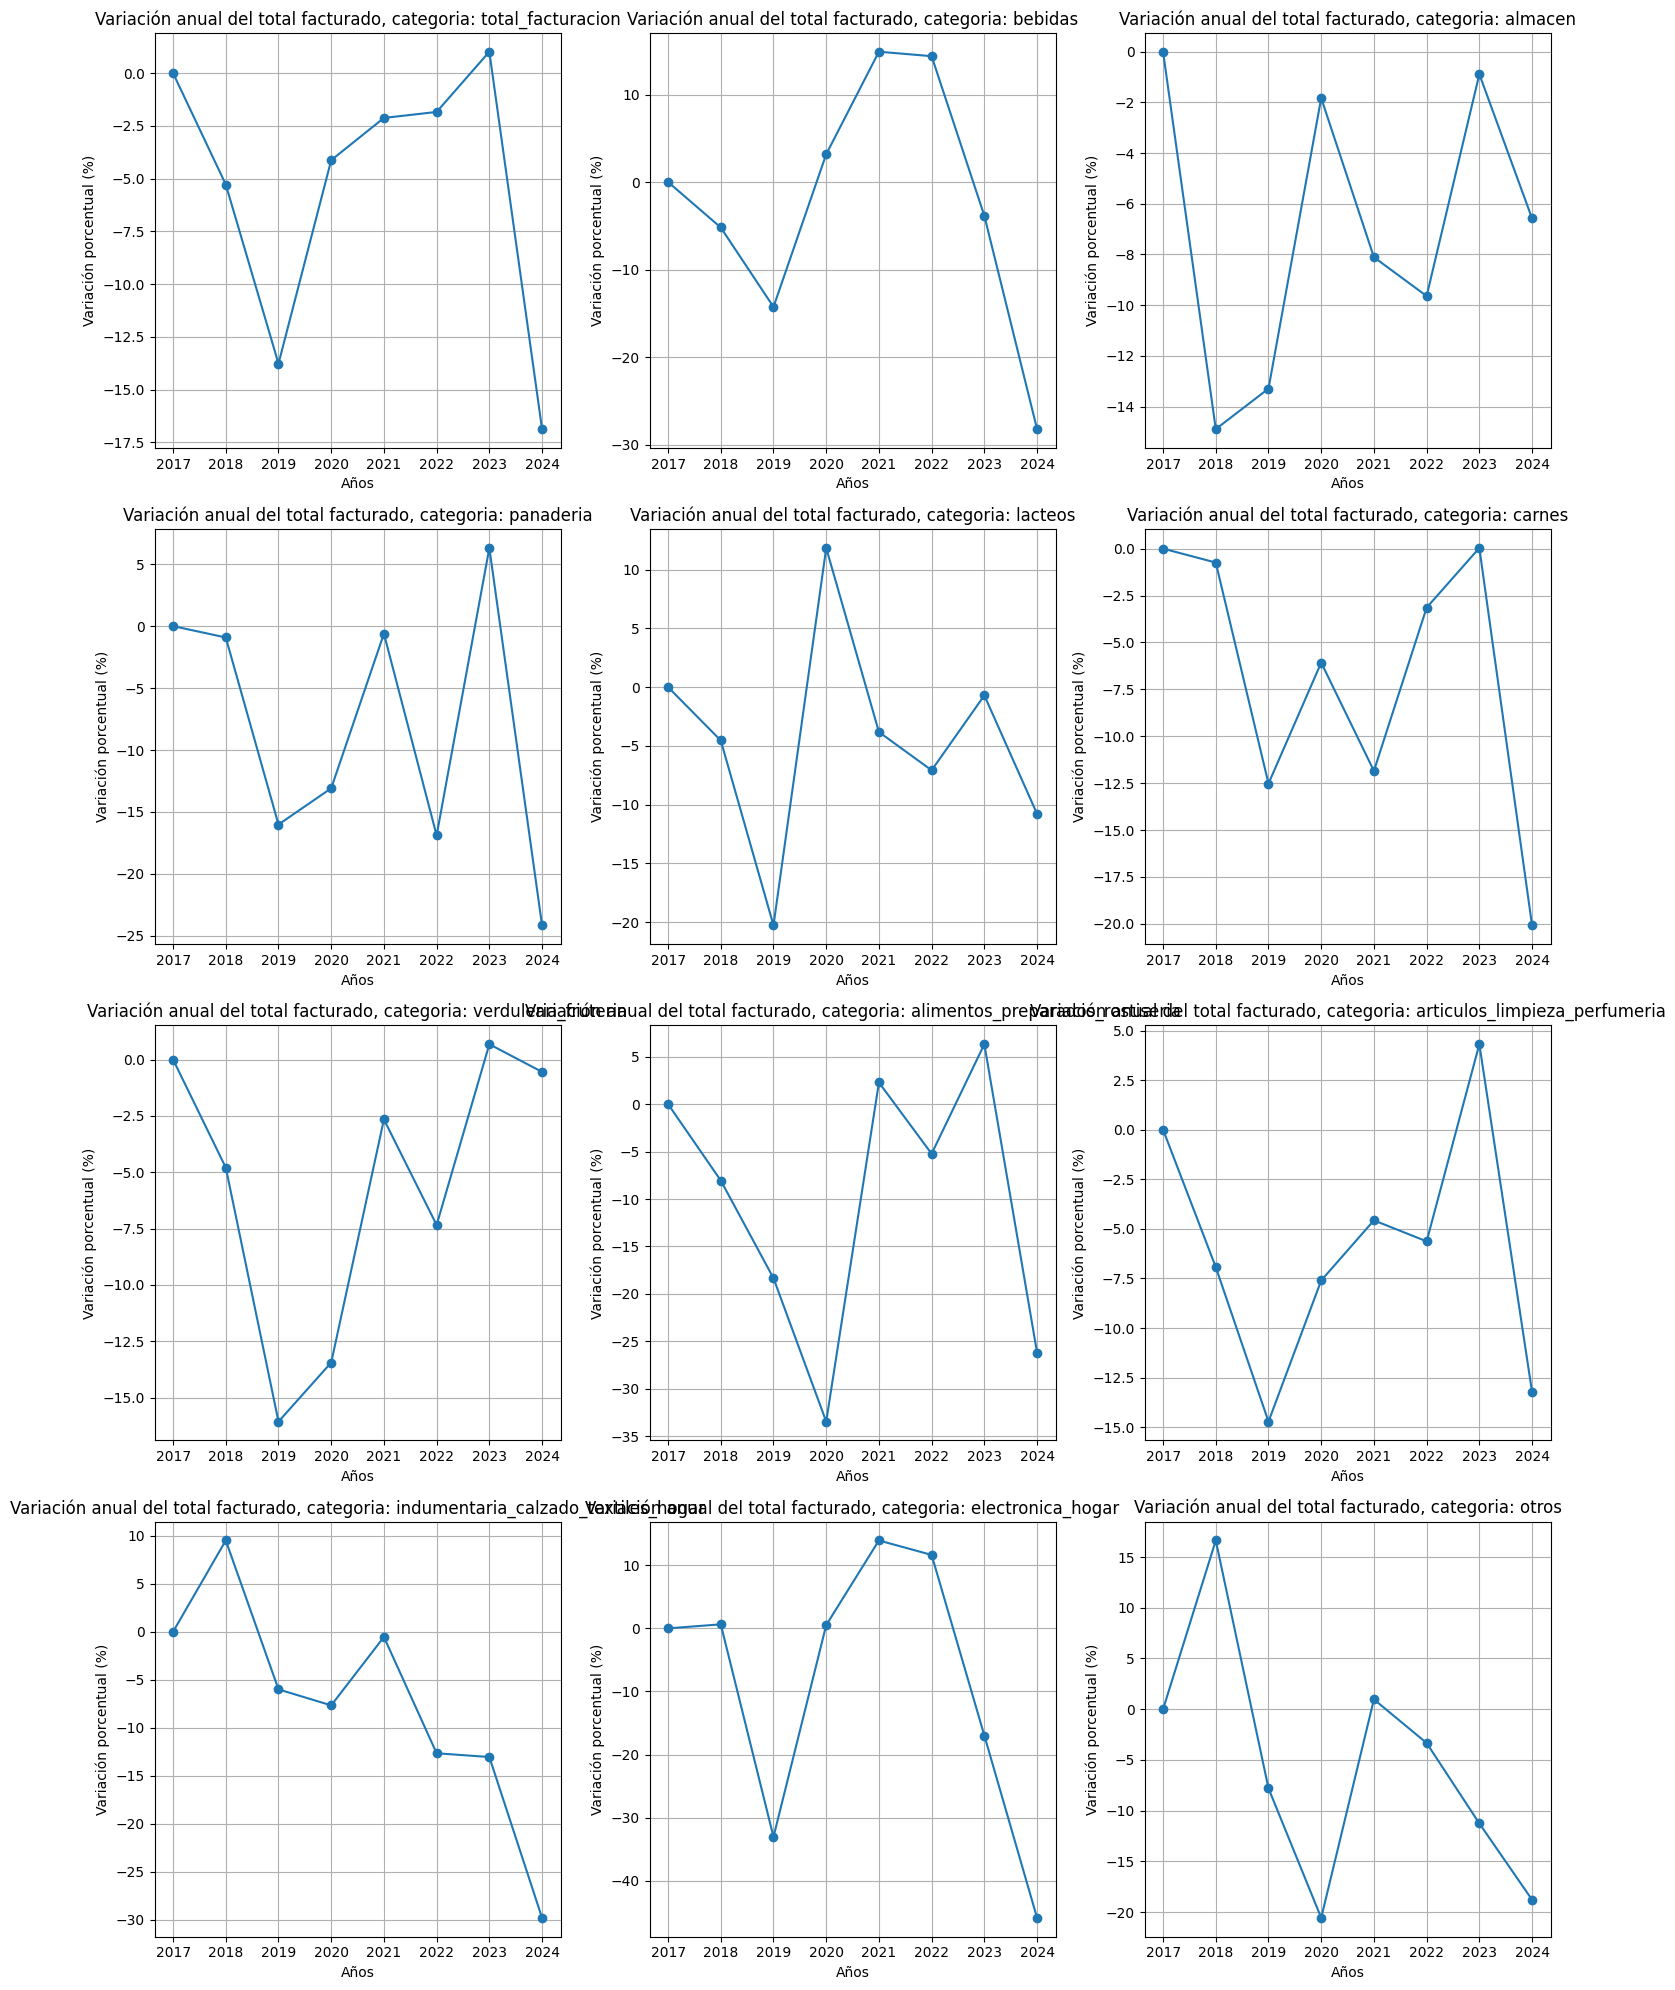

In [54]:
anios_unicos = pd.unique(df.index.year)
num_columns = 3
num_rows = 4

fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, 20))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for i, column in enumerate(columnas):
    lista_promedios = []

    # Calcular los promedios anuales
    for anio in anios_unicos:
        promedio = df[column][df.index.year == anio].mean()
        lista_promedios.append(promedio)

    # Calcular las variaciones porcentuales con respecto al año anterior
    variaciones_promedios = [0]  # La variación del primer año será 0 ya que no tiene un año anterior para comparar

    for j in range(1, len(lista_promedios)):
        variacion = (lista_promedios[j] - lista_promedios[j - 1]) / lista_promedios[j - 1] * 100
        variaciones_promedios.append(variacion)

    # Graficar las variaciones
    axes[i].plot(anios_unicos, variaciones_promedios, marker='o')
    axes[i].set_xlabel('Años')
    axes[i].set_ylabel('Variación porcentual (%)')
    axes[i].set_title(f'Variación anual {column}')
    axes[i].grid(True)

# Ajustar el diseño
plt.tight_layout()
plt.show()
